In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

from TO_sim.get_sec_r import get_r_Fun,get_rp,get_rp2,get_rp3,integrand_Rd3
from tqdm.notebook import tqdm
from parfor import parfor

In [2]:
# 저장된 npz 파일 로드
loaded_data = np.load('Simul/RR.npz', allow_pickle=True)
# 딕셔너리로 변환
RR = dict(loaded_data['RR'].item())  # .item()을 사용해 원래 딕셔너리로 변환

In [3]:
m = 6

In [4]:
Ks = np.arange(0,10.01,0.1)
ms = np.arange(0,10.02,0.1)

In [107]:
RR = {}
RR['u'] = {}
RR['d'] = {}
RR['u']['rp'] = {}
RR['d']['rp'] = {}
RR['u']['rp0'] = {}
RR['d']['rp0'] = {}

RR['u']['R'] = {}
RR['u']['R0'] = {}
RR['u']['SIG'] = {}
RR['u']['OPS'] = {}


In [ ]:
for m in tqdm(ms):
# @parfor (ms)
# def get_RR(m):
    F = get_r_Fun(m)
    R_0u = F['u']['R0'](Ks)
    idx = np.isnan(R_0u)
    K_urp = Ks[~idx]
    R_0u = R_0u[~idx]
    OPS = F['u']['OPS'](K_urp)
    _,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,m,MAX=False)
    NN = np.nan* np.zeros_like(idx)[idx]
    RR['d']['rp'][m] = np.r_[NN,rp_d]
    RR['u']['rp'][m] = np.r_[NN,rp_u]
    RR['d']['rp0'][m] = np.r_[NN,rp0_d]
    RR['u']['rp0'][m] = np.r_[NN,rp0_u]
    RR['u']['R'][m] = F['u']['R'](Ks)
    RR['u']['R0'][m] = F['u']['R0'](Ks)
    sigma = 2*rp_d * np.sqrt(1/2  - m*K_urp*R_0u / (4*(4*m**2 * OPS**2 + 1)) - ((m*K_urp*R_0u)/(2*(m**2*OPS**2 + 1)))**2)
    RR['u']['SIG'][m] = np.r_[NN,rp0_u]
    RR['u']['OPS'][m] = np.r_[NN,OPS]


In [ ]:
np.savez('Simul/RR_0.npz',RR=RR,ms=ms,Ks=Ks)

In [7]:
df = pd.DataFrame(RR)

In [8]:
df_A = pd.read_excel(f'NEW Order parameter and secondary cluster NEW.xlsm',index_col=[0,1])
df_A2 = pd.read_excel('Order parameter and secondary cluster with rsecd.xlsm',index_col=[0,1])

In [81]:
N = 5000
df_new = pd.read_excel(f'N = {N} seed = 10 QNORMAL w pv.xlsm',index_col=[0,1])

In [73]:
df

,u,d
rp,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...","{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,..."
rp0,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...","{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,..."
R,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN
R0,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN
SIG,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN
OPS,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN


In [82]:
A_RPU = pd.DataFrame(df['u']['rp'],index=Ks).to_numpy(dtype=float)
A_RPD = pd.DataFrame(df['d']['rp'],index=Ks).to_numpy(dtype=float)
A_RPU0 = pd.DataFrame(df['u']['rp0'],index=Ks).to_numpy(dtype=float)
A_RPD0 = pd.DataFrame(df['d']['rp0'],index=Ks).to_numpy(dtype=float)
A_R0 = pd.DataFrame(df['u']['R0'],index=Ks).to_numpy(dtype=float)
A_SIG = pd.DataFrame(df['u']['SIG'],index=Ks).to_numpy(dtype=float)

In [83]:
A_RP2U = pd.DataFrame(df['u']['rp'],index=Ks).to_numpy(dtype=float)
A_RP2D = pd.DataFrame(df['d']['rp'],index=Ks).to_numpy(dtype=float)
A_RP2U0 = pd.DataFrame(df['u']['rp0'],index=Ks).to_numpy(dtype=float)
A_RP2D0 = pd.DataFrame(df['d']['rp0'],index=Ks).to_numpy(dtype=float)

In [84]:
RP = df_new['r+'].unstack().to_numpy(float)
R0 = df_new['r0'].unstack().to_numpy(float)
RM = df_new['r-'].unstack().to_numpy(float)
SIG_S = df_new['sig'].unstack().to_numpy(float)

In [85]:
DRP_AS = (A_RPU0 - RP) + (A_RPU0 - RM)
R0_SA = (R0 - A_R0) 
# np.nanmin(R0P), np.nanmax(R0P)

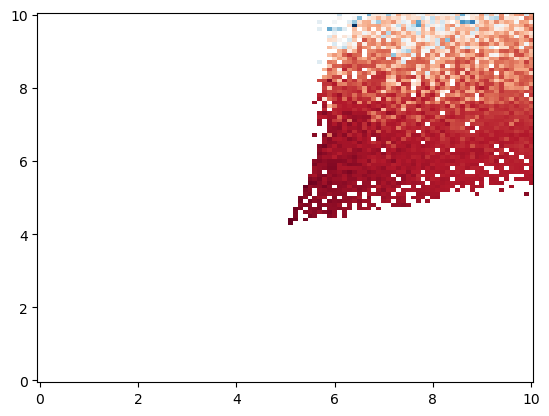

In [86]:
MM,KK = np.meshgrid(ms,Ks,indexing='ij')

plt.pcolormesh(MM,KK,DRP_AS,cmap='RdBu',shading='auto')

In [87]:
X = R0_SA.flatten()
Y = DRP_AS.flatten()
M_nnan = MM.flatten()[~np.isnan(Y)]
X_nnan = X[~np.isnan(Y)]
Y_nnan = Y[~np.isnan(Y)]
coefficients = np.polyfit(Y_nnan, X_nnan, 1)
fit_line = np.polyval(coefficients, Y_nnan)

# Calculate R-squared value for a line with slope=1 and intercept=0
fit_line_identity = Y_nnan  # y = x for slope=1 and intercept=0
residuals_identity = X_nnan - fit_line_identity
ss_res_identity = np.sum(residuals_identity**2)
ss_tot_identity = np.sum((X_nnan - np.mean(X_nnan))**2)
r_squared_identity = 1 - (ss_res_identity / ss_tot_identity)

print("R-squared for y=x:", r_squared_identity)
residuals = X_nnan - fit_line
ss_res = np.sum(residuals**2)
ss_tot = np.sum((X_nnan - np.mean(X_nnan))**2)
r_squared = 1 - (ss_res / ss_tot)

print("Coefficients:", coefficients)
print("R-squared:", r_squared)

R-squared for y=x: 0.9136637366154695
Coefficients: [0.85451843 0.00517568]
R-squared: 0.9415941902401068


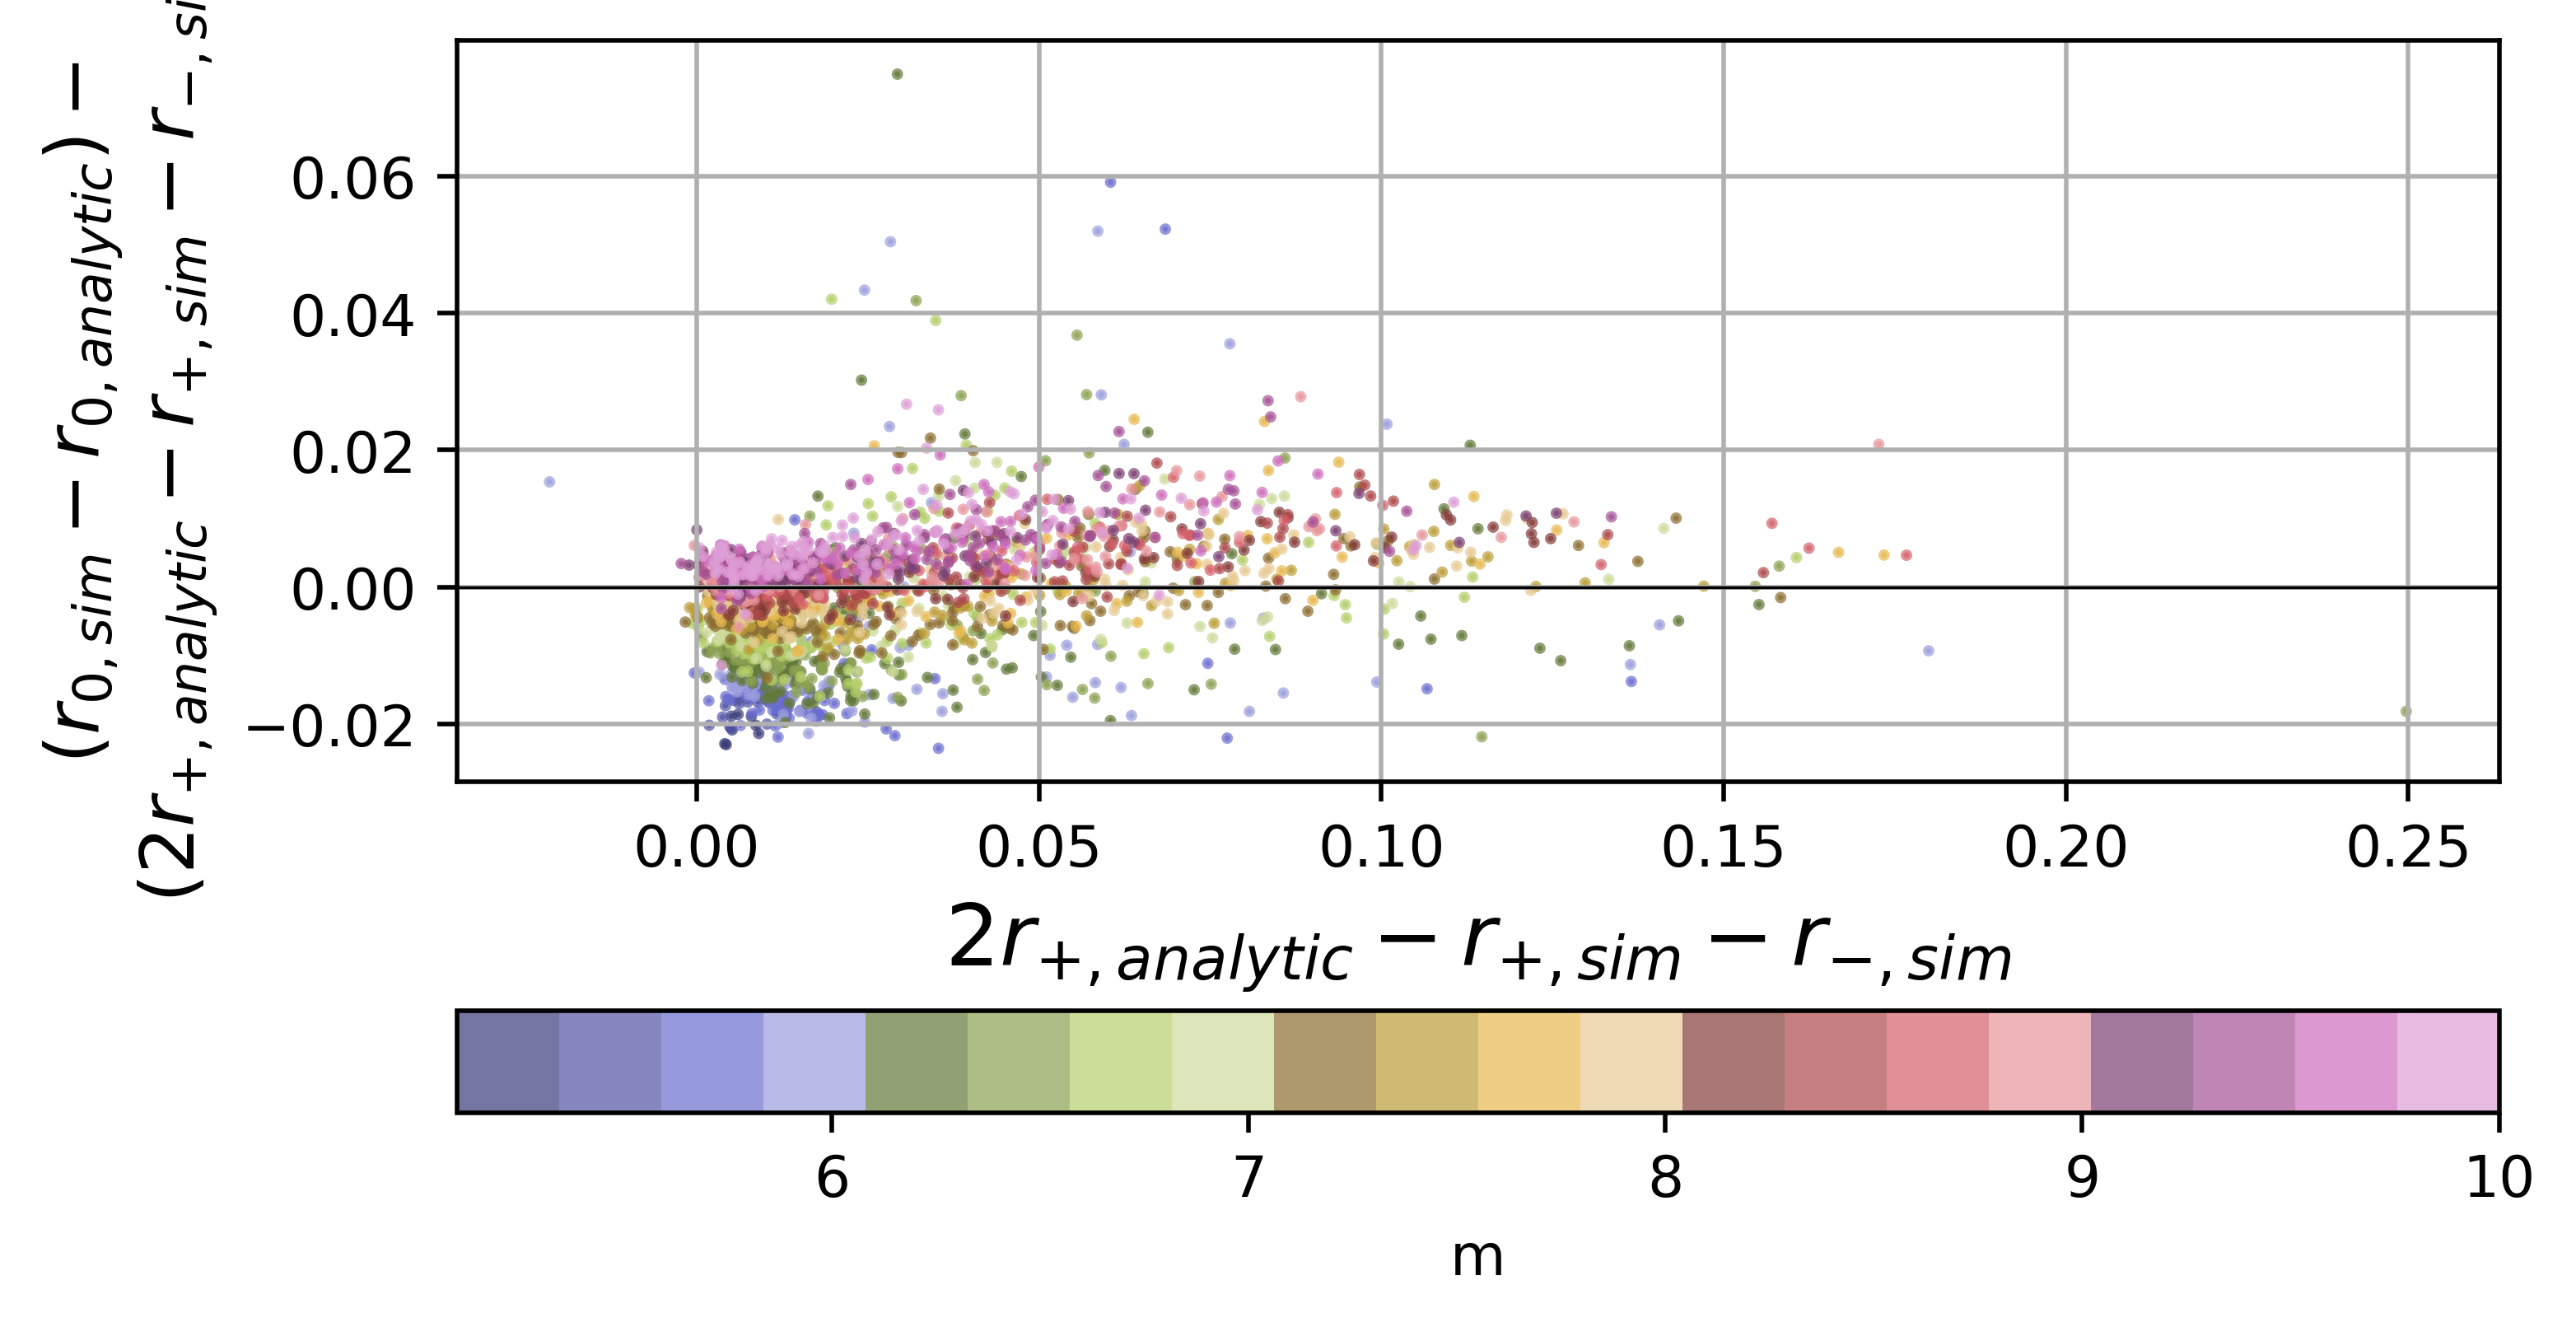

In [88]:
plt.figure(dpi=500)
# plt.plot(DRP_AS.flatten()*1.1,DRP_AS.flatten()*1.1,zorder=1,c='k',lw=0.5)
plt.axhline(0,c='k',lw=0.5)
plt.scatter(R0_SA.flatten(),DRP_AS.flatten()-R0_SA.flatten(),s=1,c=MM.flatten(),alpha=0.7,cmap='tab20b')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel(r'$(r_{0,sim}-r_{0,analytic})-$' + '\n' + r'$(2r_{+,analytic}-r_{+,sim}-r_{-,sim})$', fontsize=13)
plt.xlabel(r'$2r_{+,analytic}-r_{+,sim}-r_{-,sim}$',fontsize=15)
plt.colorbar(label='m',orientation='horizontal')
plt.grid()


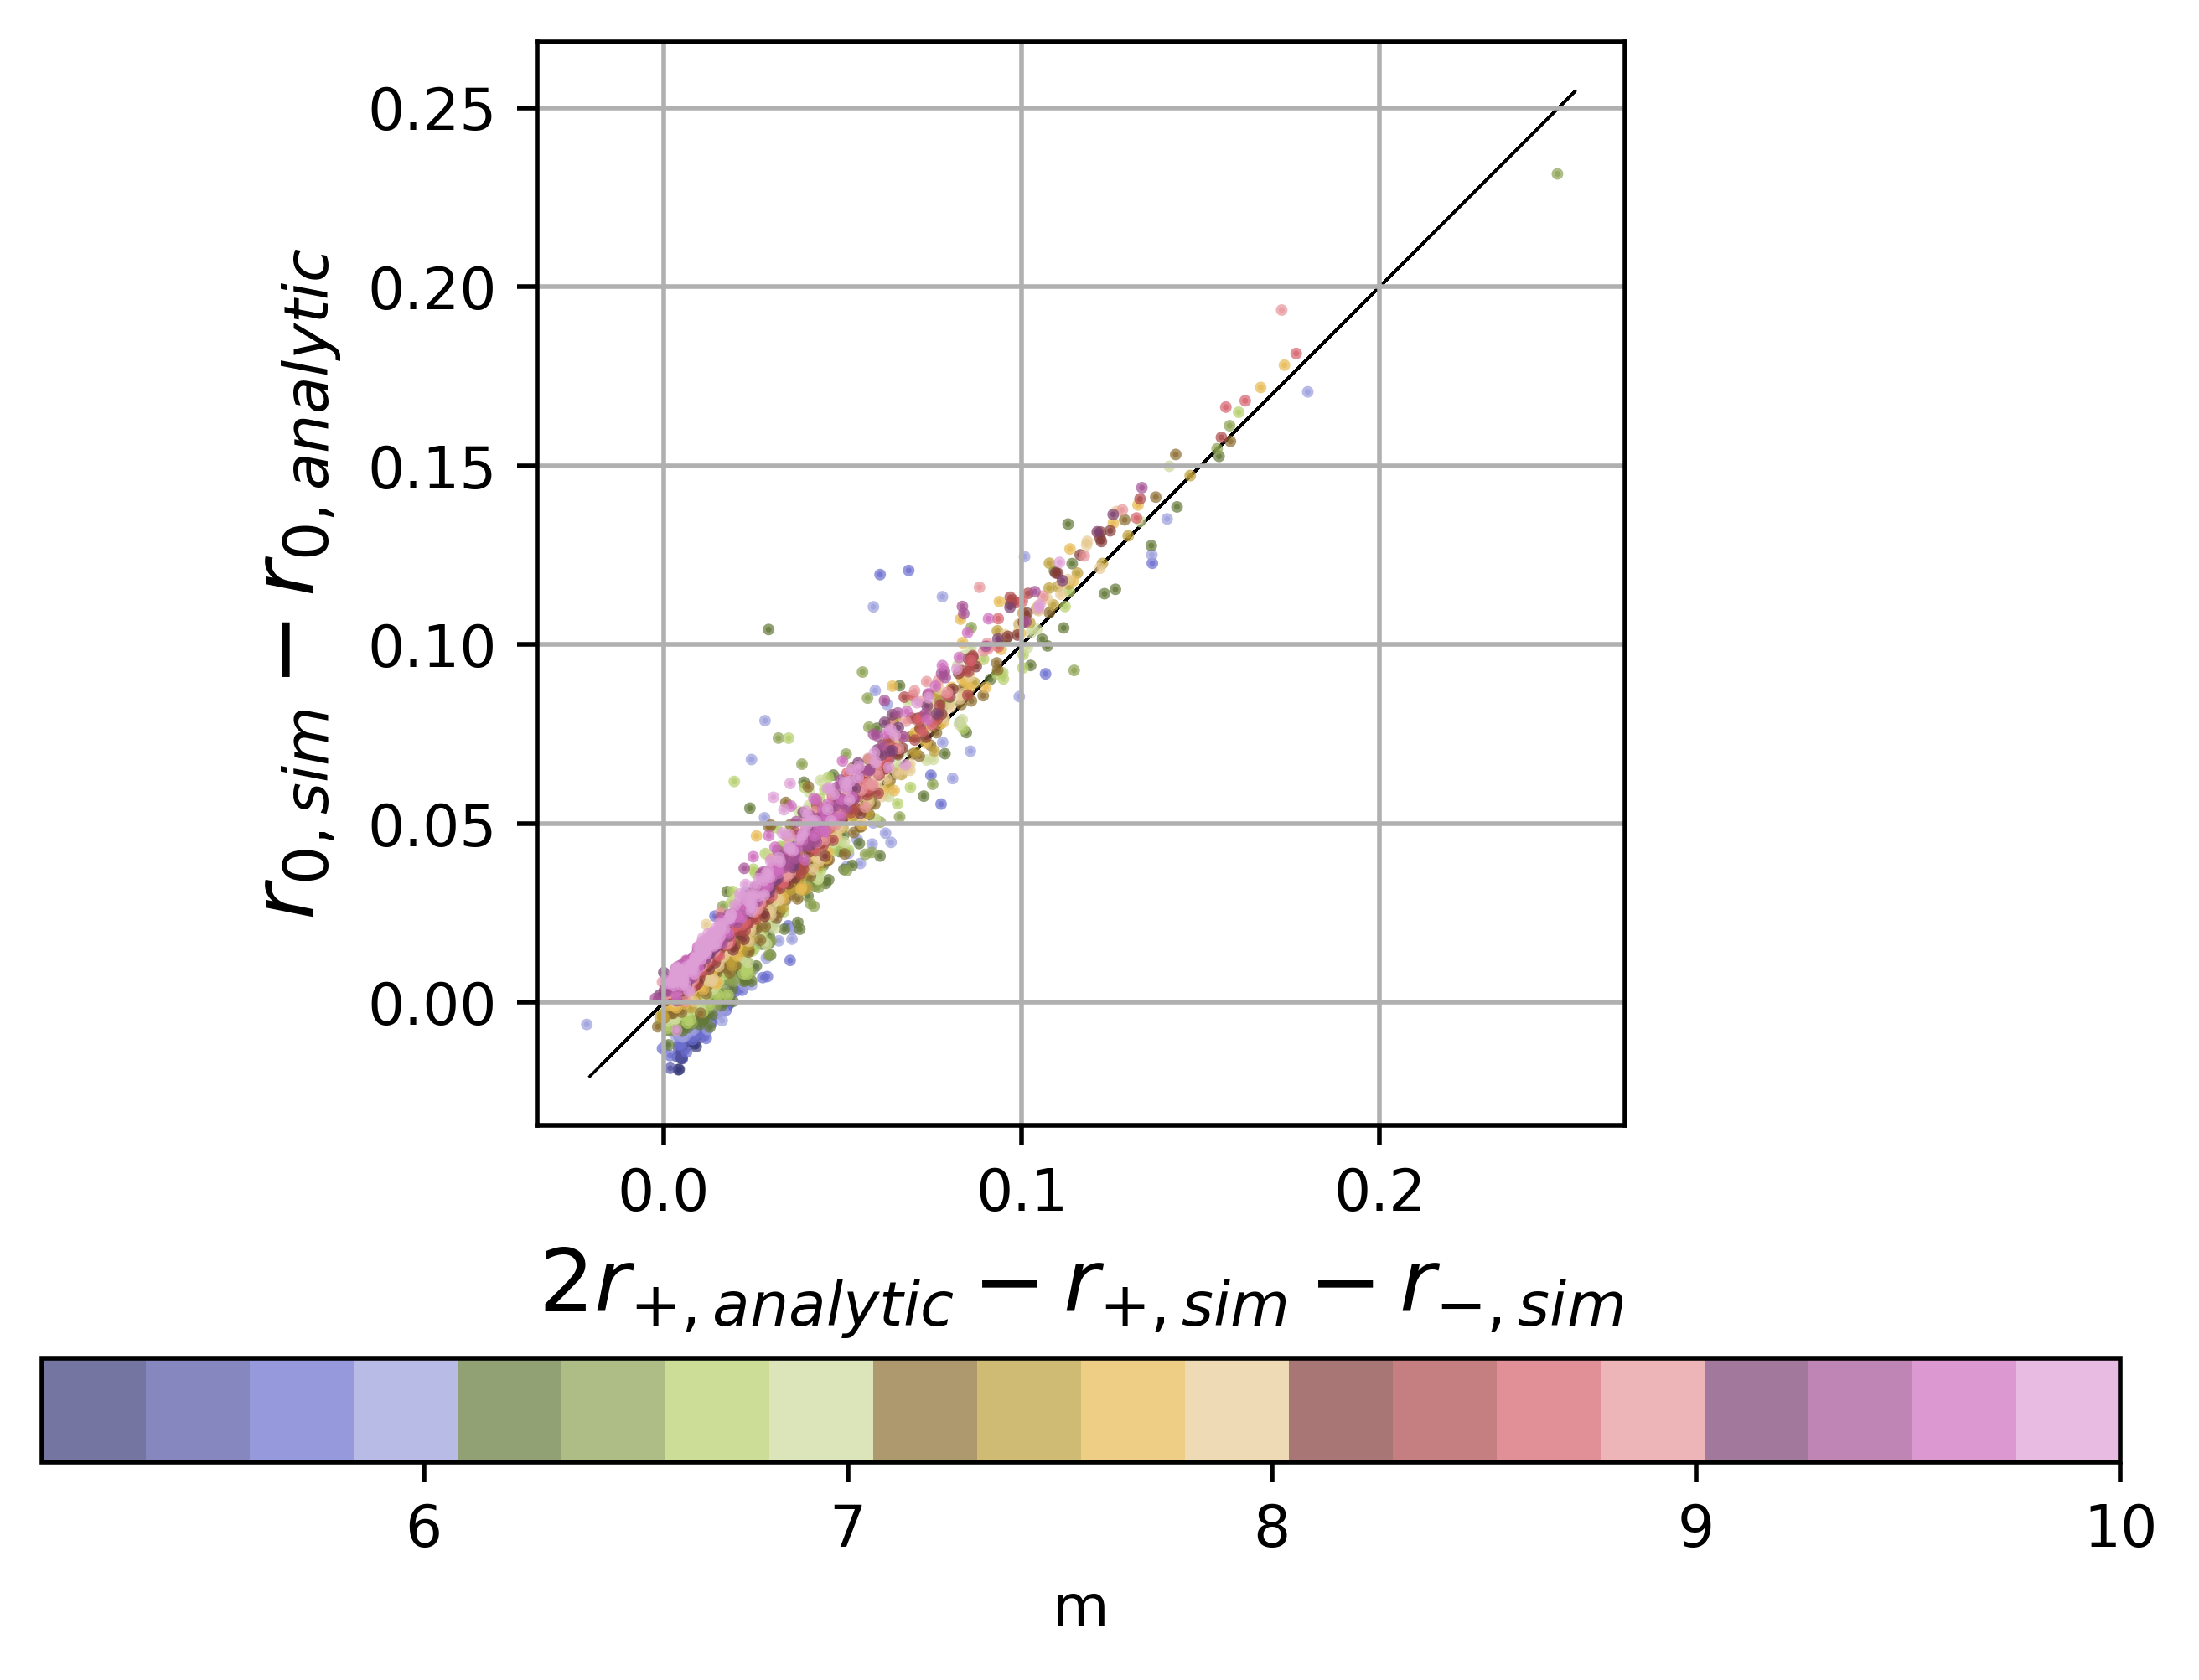

In [89]:
plt.figure(dpi=500)
plt.plot(DRP_AS.flatten()*1.1,DRP_AS.flatten()*1.1,zorder=1,c='k',lw=0.5)
plt.scatter(R0_SA.flatten(),DRP_AS.flatten(),s=1,c=MM.flatten(),alpha=0.7,cmap='tab20b')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel(r'$r_{0,sim}-r_{0,analytic}$',fontsize=15)
plt.xlabel(r'$2r_{+,analytic}-r_{+,sim}-r_{-,sim}$',fontsize=15)
plt.colorbar(label='m',orientation='horizontal')
plt.grid()

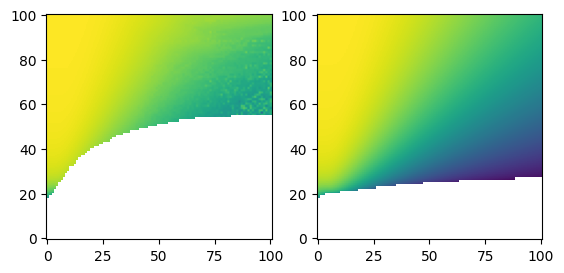

In [125]:
plt.subplot(121)
plt.imshow(R0,origin='lower')
plt.subplot(122)

plt.imshow(R0A,origin='lower')

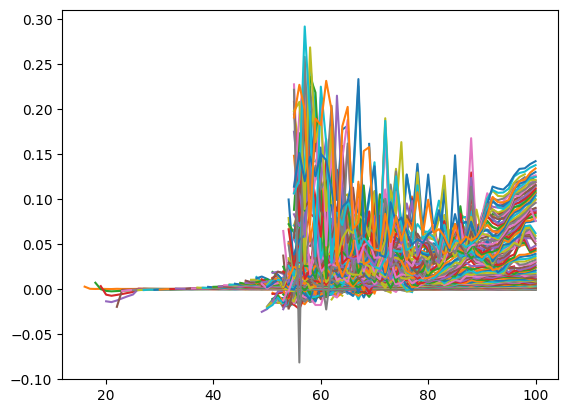

In [126]:
plt.plot(DRP_AS);
plt.plot(R0_SA);

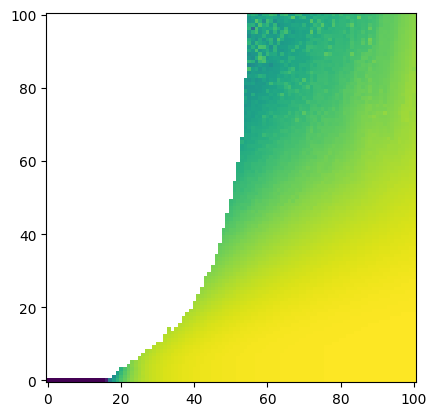

In [207]:
plt.imshow(R0.T,origin='lower')

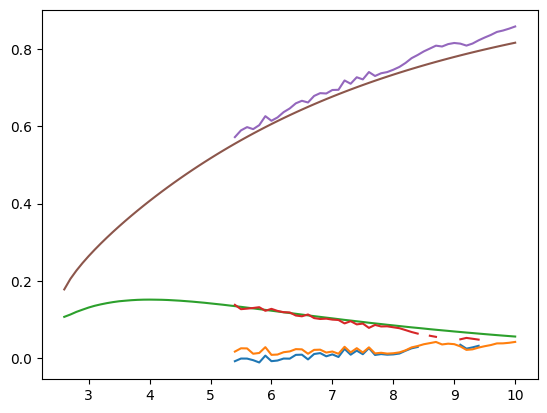

In [127]:
plt.plot(Ks,DRP_AS[:,70])
plt.plot(Ks,R0_SA[:,70])
plt.plot(Ks,RPU[:,70])
plt.plot(Ks,RP[:,70])
plt.plot(Ks,R0[:,70])
plt.plot(Ks,R0A[:,70])

In [92]:
A_R0P = A_R0 + 2 * A_RPU0
S_R0P = R0 + RP + RM


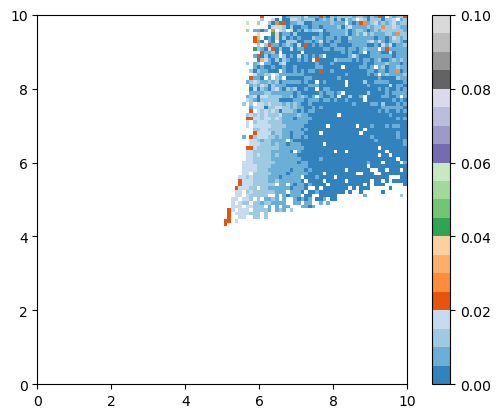

In [90]:
plt.imshow(abs(R0_SA.T - DRP_AS.T),origin='lower',vmin=0,vmax=0.1,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
# plt.contourf(abs(R0_SA.T - DRP_AS.T),origin='lower')#,vmin=0,vmax=0.3,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()

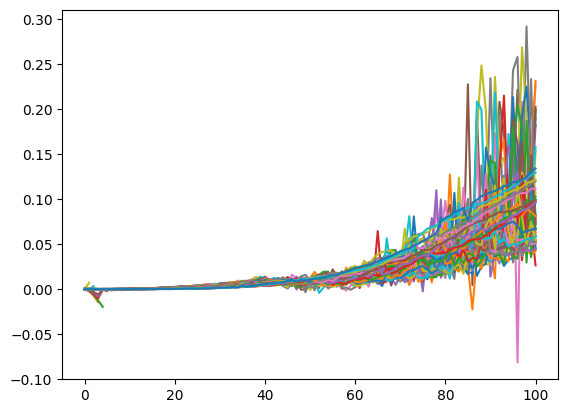

In [208]:
# plt.plot(R0A.T);
plt.plot((R0-R0A).T);

In [ ]:
# RP,R0,RM : 시뮬레이션 결과
# RPU, RPD, RPU0, RPD0 : 이론 결과
# DRP_AS = (2*RPU) - (RM + RP)
# R0_SA = (R0 - R0A) 
# np.nanmin(R0P), np.nanmax(R0P)

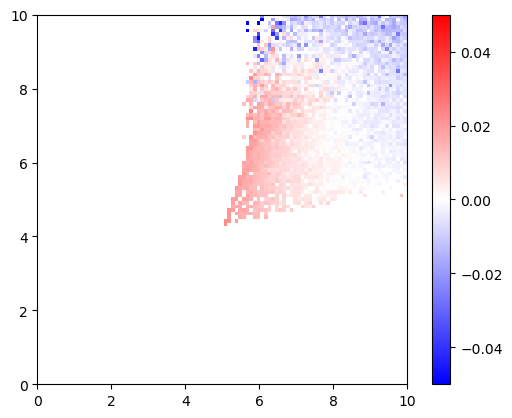

In [93]:
plt.imshow((S_R0P - A_R0P).T,origin='lower',vmin=-0.05,vmax=0.05,cmap='bwr',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()

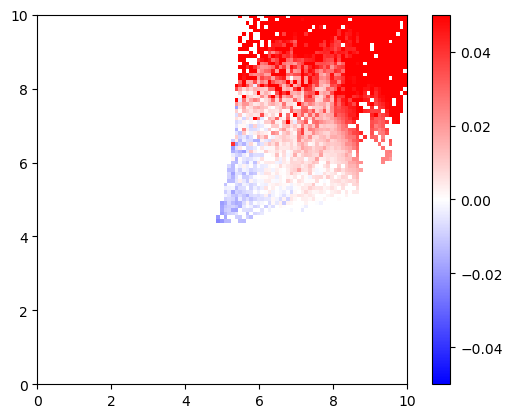

In [40]:
plt.imshow(DRP_AS.T,origin='lower',vmin=-0.05,vmax=0.05,cmap='bwr',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()

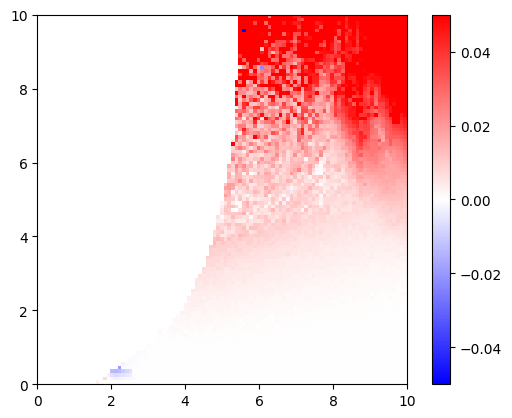

In [212]:
plt.imshow(R0_SA.T,origin='lower',vmin=-0.05,vmax=0.05,cmap='bwr',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()  

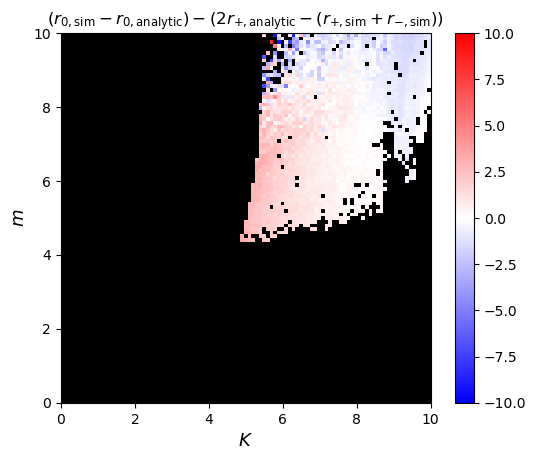

In [49]:
plt.imshow((100*(S_R0P - A_R0P)/A_R0P).T, origin='lower', vmin=-10, vmax=10, cmap='bwr', extent=[Ks.min(), 10, ms.min(), 10])
plt.gca().set_facecolor('black')  # Set the background color of the plot
# R0_SA : 메인 클러스터가 2차 클러스터를 흡수한 양
# DRP_AS : 2차 클러스터가 메인클러스터에 흡수된 양
# plt.contourf((R0_SA.T - DRP_AS.T), origin='lower', vmin=-0.1, vmax=0.1, levels=20, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])

plt.ylabel(r'$m$', fontsize=13)
plt.xlabel(r'$K$', fontsize=13)
plt.title(r'$(r_{0,\rm{sim}} - r_{0,\rm{analytic}}) - (2 r_{+,\rm{analytic}} - (r_{+,\rm{sim}} + r_{-,\rm{sim}}) )$')
# plt.contourf(abs(R0_SA.T - DRP_AS.T), origin='lower')#, vmin=0, vmax=0.3, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])
plt.colorbar()

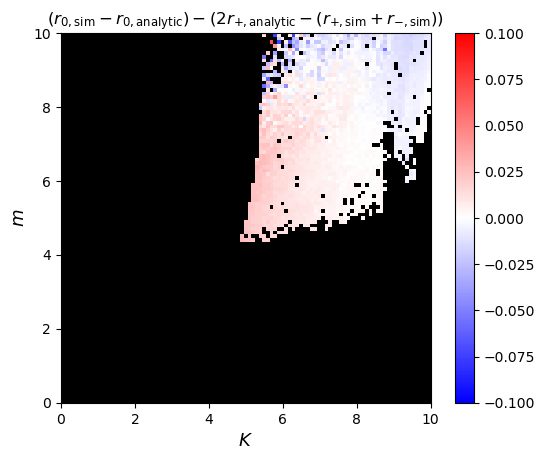

In [ ]:
plt.imshow((R0_SA.T - DRP_AS.T), origin='lower', vmin=-0.1, vmax=0.1, cmap='bwr', extent=[Ks.min(), 10, ms.min(), 10])
plt.gca().set_facecolor('black')  # Set the background color of the plot
# R0_SA : 메인 클러스터가 2차 클러스터를 흡수한 양
# DRP_AS : 2차 클러스터가 메인클러스터에 흡수된 양
# plt.contourf((R0_SA.T - DRP_AS.T), origin='lower', vmin=-0.1, vmax=0.1, levels=20, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])

plt.ylabel(r'$m$', fontsize=13)
plt.xlabel(r'$K$', fontsize=13)
plt.title(r'$(r_{0,\rm{sim}} - r_{0,\rm{analytic}}) - (2 r_{+,\rm{analytic}} - (r_{+,\rm{sim}} + r_{-,\rm{sim}}) )$')
# plt.contourf(abs(R0_SA.T - DRP_AS.T), origin='lower')#, vmin=0, vmax=0.3, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])
plt.colorbar()

In [155]:
A = np.where(SIG_S > 1e-2)

In [156]:
B = np.where(SIG_S > 5e-3,abs(SIG_S -SIG),np.nan)

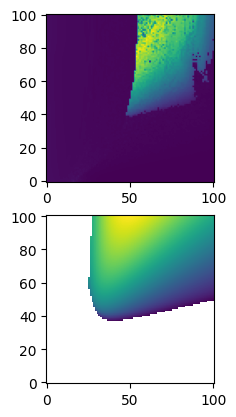

In [153]:
plt.subplot(211)
plt.imshow(SIG_S.T,origin='lower')
plt.subplot(212)
plt.imshow(SIG.T,origin='lower')

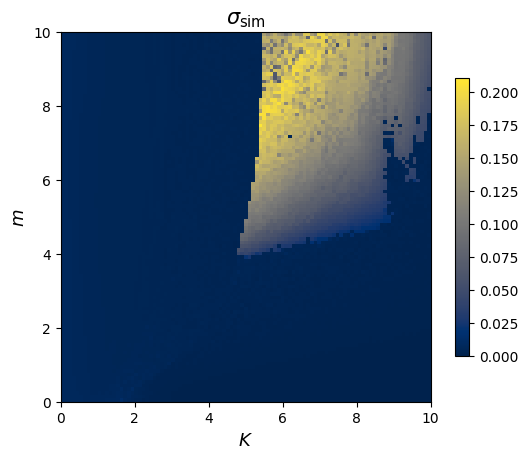

In [145]:
plt.imshow(SIG_S.T,origin='lower',vmin=0,cmap='cividis',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\sigma_{\rm{sim}}$', fontsize=15)
plt.gca().set_aspect('equal')

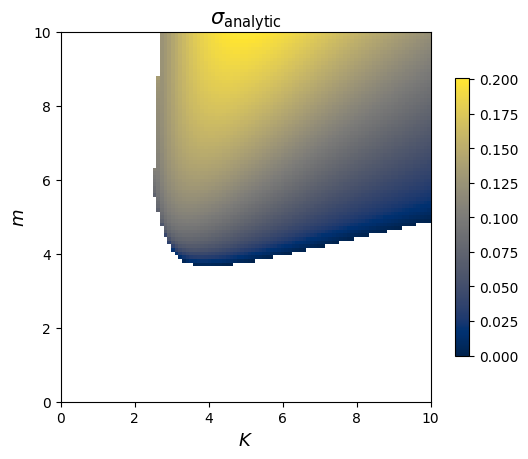

In [146]:
plt.imshow(SIG.T,origin='lower',vmin=0,cmap='cividis',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\sigma_{\rm{analytic}}$', fontsize=15)
plt.gca().set_aspect('equal')

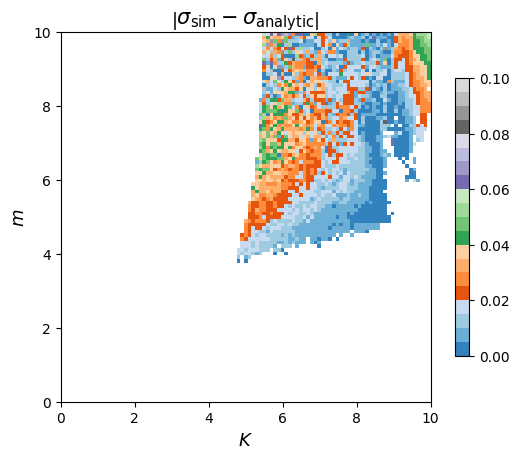

In [158]:
plt.imshow(B.T,origin='lower',vmin=0,vmax=0.1,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\left|\sigma_{\rm{sim}} - \sigma_{\rm{analytic}}\right|$', fontsize=15)
plt.gca().set_aspect('equal')

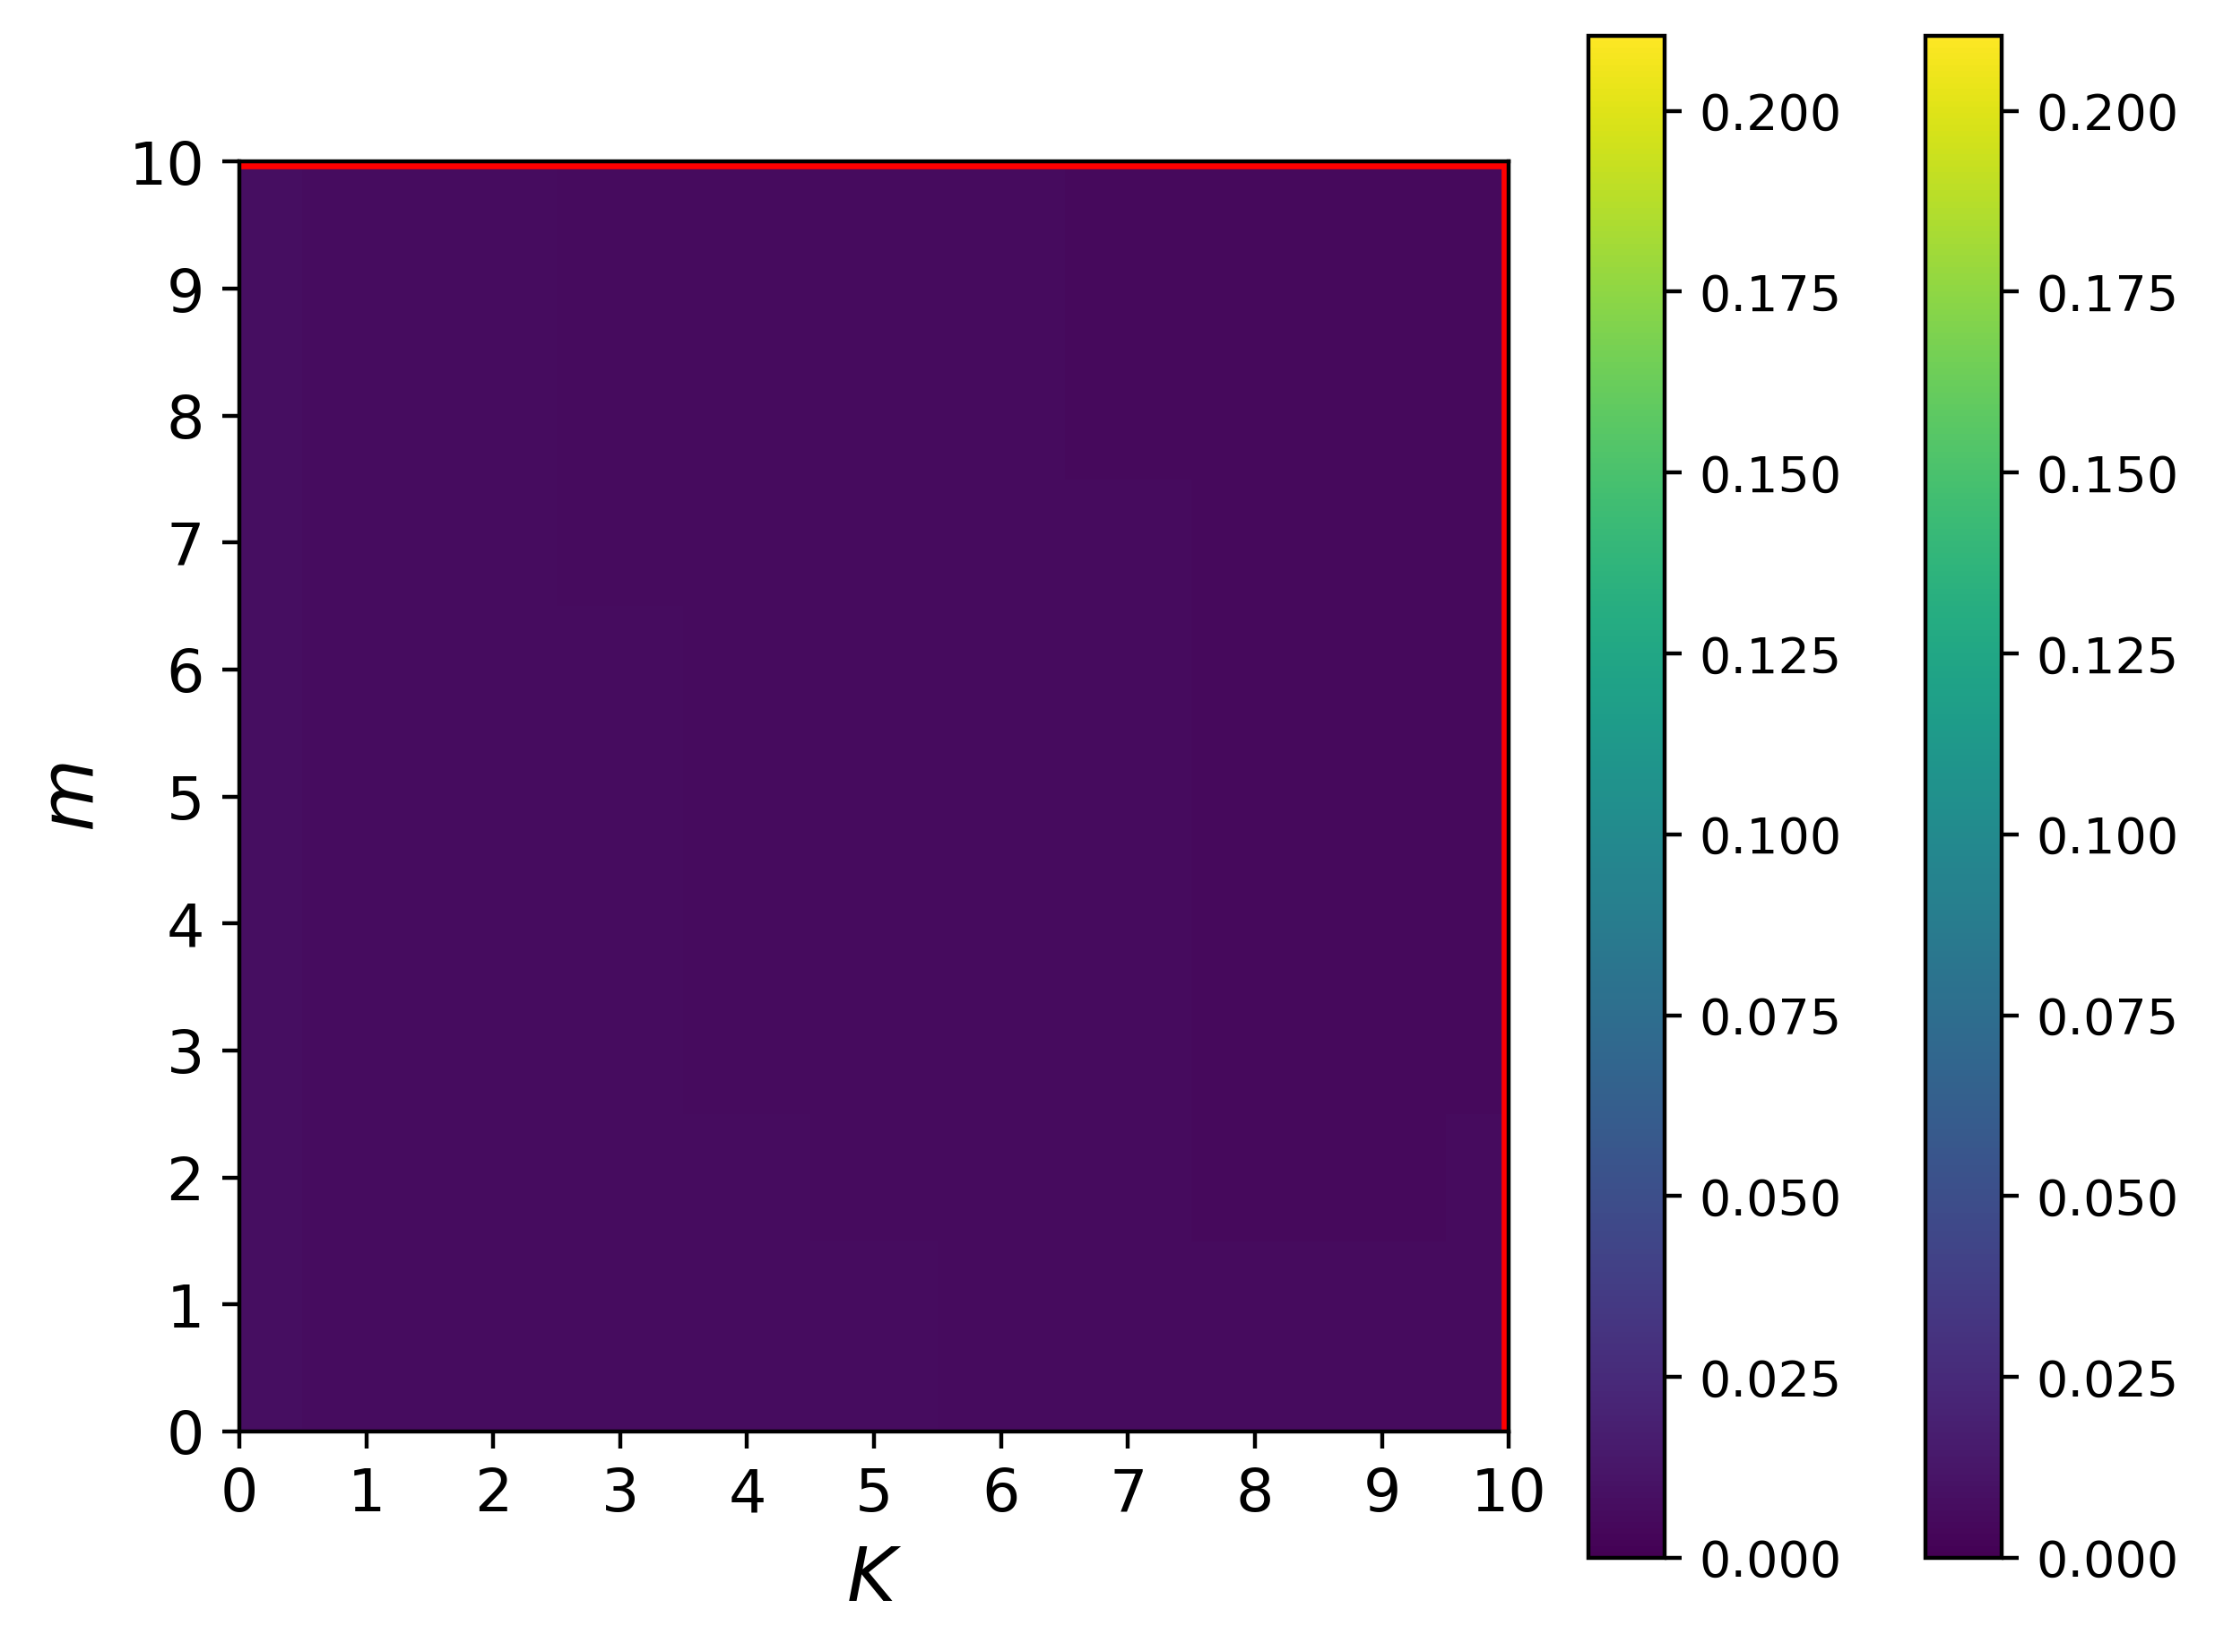

In [51]:
import matplotlib.colors as mcolors
plt.figure(dpi=400)
# imshow를 사용하여 RP2U-RPU의 차이를 시각화
plt.imshow(SIG.T, origin='lower',cmap='Blues', aspect='auto', extent=[Ks.min(), Ks.max(), ms.min(), ms.max()])
plt.imshow(SIG.T, origin='lower',cmap='inferno', aspect='auto', extent=[Ks.min(), Ks.max(), ms.min(), ms.max()],vmax=0.2,vmin=0)

plt.imshow(df_new['sig'].unstack().to_numpy(float).T,origin='lower')
plt.colorbar()
# plt.grid()
plt.colorbar()

# x축과 y축의 tick 설정
plt.xticks(np.linspace(Ks.min(), 10, num=11))
plt.yticks(np.linspace(0, 10, num=11))

# contour 라인을 여러 개 그리기
# contour_levels = np.logspace(-3, 0, 10)  # 원하는 contour 레벨 설정
# contour_colors = ['white', 'red', 'blue', 'green', 'yellow', 'cyan', 'magenta', 'black', 'orange', 'purple']
# im = plt.contour(Ks, ms, (RP2U - RPU).T, levels=contour_levels, colors=contour_colors)

# colorbar 추가
# plt.clabel(im, inline=True, fontsize=10, colors='black')
plt.hlines(10,0,10,color='red',lw=3)
plt.vlines(10,0,10,color='red',lw=3)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$m$',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [24]:
m = 10
F = get_r_Fun(m)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)
Ks_,rp_d,rp,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,m,MAX=False)
Ks_,rp2_d,rp2,rp20_d,rp20_u = get_rp2(K_urp,R_0u,OPS,m,MAX=False)
Ks_,rp2_d,rp3,rp20_d,rp20_u = get_rp3(K_urp,R_0u,OPS,m,MAX=False)

F_Krp = interpolate.interp1d(Ks_,rp2,bounds_error=False)
F_Krp3 = interpolate.interp1d(Ks_,rp3,bounds_error=False)

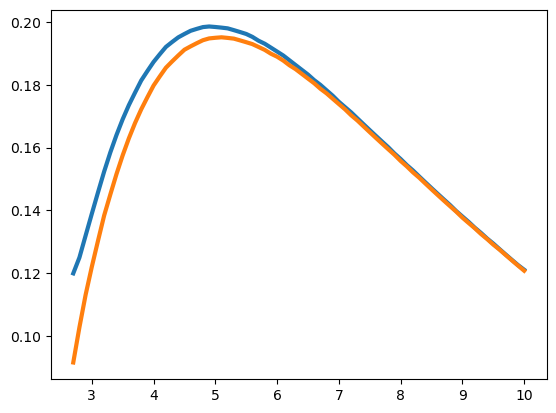

In [21]:
plt.plot(Ks_,rp2,label=r'before',lw=3)
plt.plot(Ks_,rp,label=r'before',lw=3)



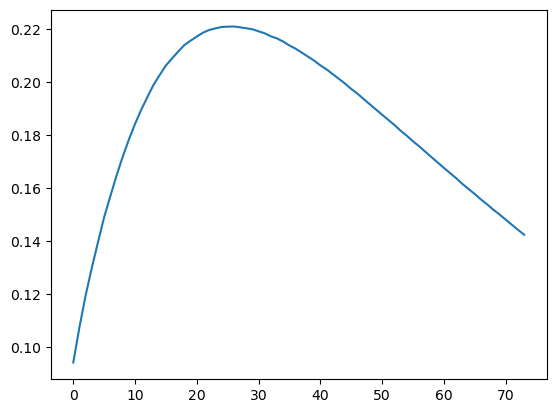

In [28]:
plt.plot(sigma)